# Activation Difference Visualization

This notebook visualizes the differences between truthful and strategic activations extracted from GPT-OSS-20B.

The steering vectors are computed as: `truthful_activations - strategic_activations`

This notebook loads the **individual response averages** (truthful_response_avg.pt, strategic_response_avg.pt) and computes differences on the fly.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from scipy import stats
from sklearn.decomposition import PCA

# Set style with larger fonts
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 20


In [ ]:
# Configuration
MODEL_DIR_NAME = "gpt-oss-20b"  # Change if using a different model
LAYER_IDX = 20  # Layer used for single-layer vector
EXTRACTION_DIR = Path(f"results/{MODEL_DIR_NAME}/extraction")

print(f"Loading vectors from: {EXTRACTION_DIR}")


Loading vectors from: steering_vectors/gpt-oss-20b/extraction


In [68]:
# Load per-sample vectors (shape: [num_samples, layers, hidden_dim])
truthful_response_samples = torch.load(EXTRACTION_DIR / "truthful_response_samples.pt", map_location="cpu")
strategic_response_samples = torch.load(EXTRACTION_DIR / "strategic_response_samples.pt", map_location="cpu")

# Compute averages: [num_samples, layers, hidden_dim] -> [layers, hidden_dim]
truthful_response_avg = truthful_response_samples.mean(dim=0)
strategic_response_avg = strategic_response_samples.mean(dim=0)

# Compute differences on the fly (truthful - strategic)
response_avg_diff = truthful_response_avg - strategic_response_avg
single_layer_vector = response_avg_diff[LAYER_IDX]  # Single layer difference

# Load metadata
with open(EXTRACTION_DIR / f"metadata_layer{LAYER_IDX}.json", 'r') as f:
    metadata = json.load(f)

print(f"Model: {metadata['model']}")
print(f"Layer: {metadata['layer']}")
print(f"Number of samples: {metadata['num_samples']}")
print(f"\nVector shapes:")
print(f"  Truthful response samples: {truthful_response_samples.shape} [num_samples × layers × hidden_dim]")
print(f"  Strategic response samples: {strategic_response_samples.shape} [num_samples × layers × hidden_dim]")
print(f"  Truthful response avg (computed): {truthful_response_avg.shape} [layers × hidden_dim]")
print(f"  Strategic response avg (computed): {strategic_response_avg.shape} [layers × hidden_dim]")
print(f"  Response avg diff (computed): {response_avg_diff.shape} [layers × hidden_dim]")
print(f"  Single layer ({LAYER_IDX}): {single_layer_vector.shape} [hidden_dim]")


Model: openai/gpt-oss-20b
Layer: 20
Number of samples: 10

Vector shapes:
  Truthful response samples: torch.Size([10, 25, 2880]) [num_samples × layers × hidden_dim]
  Strategic response samples: torch.Size([10, 25, 2880]) [num_samples × layers × hidden_dim]
  Truthful response avg (computed): torch.Size([25, 2880]) [layers × hidden_dim]
  Strategic response avg (computed): torch.Size([25, 2880]) [layers × hidden_dim]
  Response avg diff (computed): torch.Size([25, 2880]) [layers × hidden_dim]
  Single layer (20): torch.Size([2880]) [hidden_dim]


## 1. Activation Magnitudes Across Layers


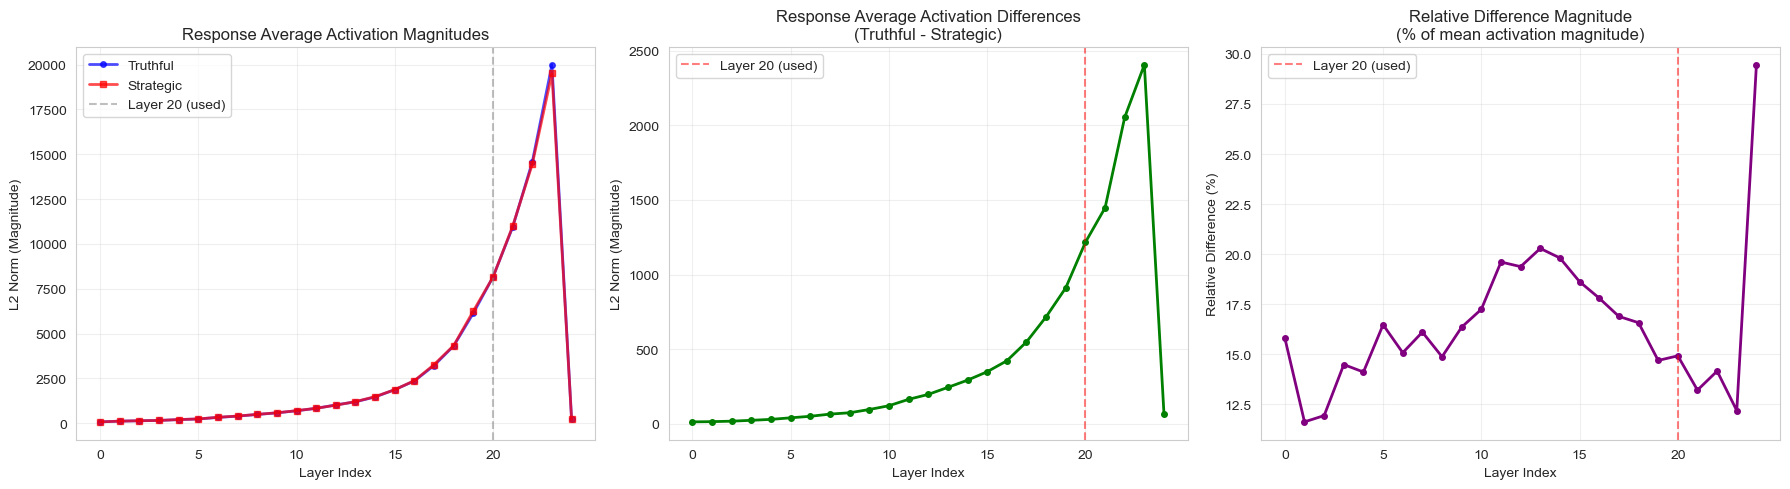


Statistics:
  Truthful response - Mean magnitude: 3184.1150, Max: 19989.5195 (layer 23)
  Strategic response - Mean magnitude: 3171.4451, Max: 19503.1719 (layer 23)
  Difference - Mean magnitude: 462.0453, Max: 2407.2776 (layer 23)
  Relative difference at layer 20: 14.92%


In [ ]:
# Compute L2 norms (magnitudes) for each layer
truthful_response_norms = torch.norm(truthful_response_avg, dim=1).numpy()
strategic_response_norms = torch.norm(strategic_response_avg, dim=1).numpy()
response_diff_norms = torch.norm(response_avg_diff, dim=1).numpy()

num_layers = len(truthful_response_norms) - 1  # -1 because we include layer 0 (embeddings)
layer_indices = np.arange(num_layers + 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Individual magnitudes
axes[0].plot(layer_indices, truthful_response_norms, marker='o', linewidth=2, markersize=4, 
             color='blue', label='Truthful', alpha=0.7)
axes[0].plot(layer_indices, strategic_response_norms, marker='s', linewidth=2, markersize=4, 
             color='red', label='Strategic', alpha=0.7)
axes[0].axvline(x=LAYER_IDX, color='gray', linestyle='--', alpha=0.5, label=f'Layer {LAYER_IDX} (used)')
axes[0].set_xlabel('Layer Index', fontsize=16)
axes[0].set_ylabel('L2 Norm (Magnitude)', fontsize=16)
axes[0].set_title('Response Average Activation Magnitudes', fontsize=18, fontweight='bold')
axes[0].set_xticks(layer_indices[::5])
axes[0].tick_params(labelsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=14)

# Plot 2: Difference magnitude
axes[1].plot(layer_indices, response_diff_norms, marker='o', linewidth=2, markersize=4, color='green')
axes[1].axvline(x=LAYER_IDX, color='r', linestyle='--', alpha=0.5, label=f'Layer {LAYER_IDX} (used)')
axes[1].set_xlabel('Layer Index', fontsize=16)
axes[1].set_ylabel('L2 Norm (Magnitude)', fontsize=16)
axes[1].set_title('Response Average Activation Differences\n(Truthful - Strategic)', fontsize=18, fontweight='bold')
axes[1].set_xticks(layer_indices[::5])
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=14)
axes[1].tick_params(labelsize=14)

# Plot 3: Relative difference (difference / mean magnitude)
mean_magnitude = (truthful_response_norms + strategic_response_norms) / 2
relative_diff = response_diff_norms / (mean_magnitude + 1e-8)  # Avoid division by zero
axes[2].plot(layer_indices, relative_diff * 100, marker='o', linewidth=2, markersize=4, color='purple')
axes[2].axvline(x=LAYER_IDX, color='r', linestyle='--', alpha=0.5, label=f'Layer {LAYER_IDX} (used)')
axes[2].set_xlabel('Layer Index', fontsize=16)
axes[2].set_ylabel('Relative Difference (%)', fontsize=16)
axes[2].set_title('Relative Difference Magnitude\n(% of mean activation magnitude)', fontsize=18, fontweight='bold')
axes[2].set_xticks(layer_indices[::5])
axes[2].grid(True, alpha=0.3)
axes[2].legend(fontsize=14)
axes[2].tick_params(labelsize=14)

plt.tight_layout()
plt.show()

print(f"\nStatistics:")
print(f"  Truthful response - Mean magnitude: {truthful_response_norms.mean():.4f}, Max: {truthful_response_norms.max():.4f} (layer {truthful_response_norms.argmax()})")
print(f"  Strategic response - Mean magnitude: {strategic_response_norms.mean():.4f}, Max: {strategic_response_norms.max():.4f} (layer {strategic_response_norms.argmax()})")
print(f"  Difference - Mean magnitude: {response_diff_norms.mean():.4f}, Max: {response_diff_norms.max():.4f} (layer {response_diff_norms.argmax()})")
print(f"  Relative difference at layer {LAYER_IDX}: {relative_diff[LAYER_IDX]*100:.2f}%")


## 2. Direct Comparison: Truthful vs Strategic Activations (Layer 20)


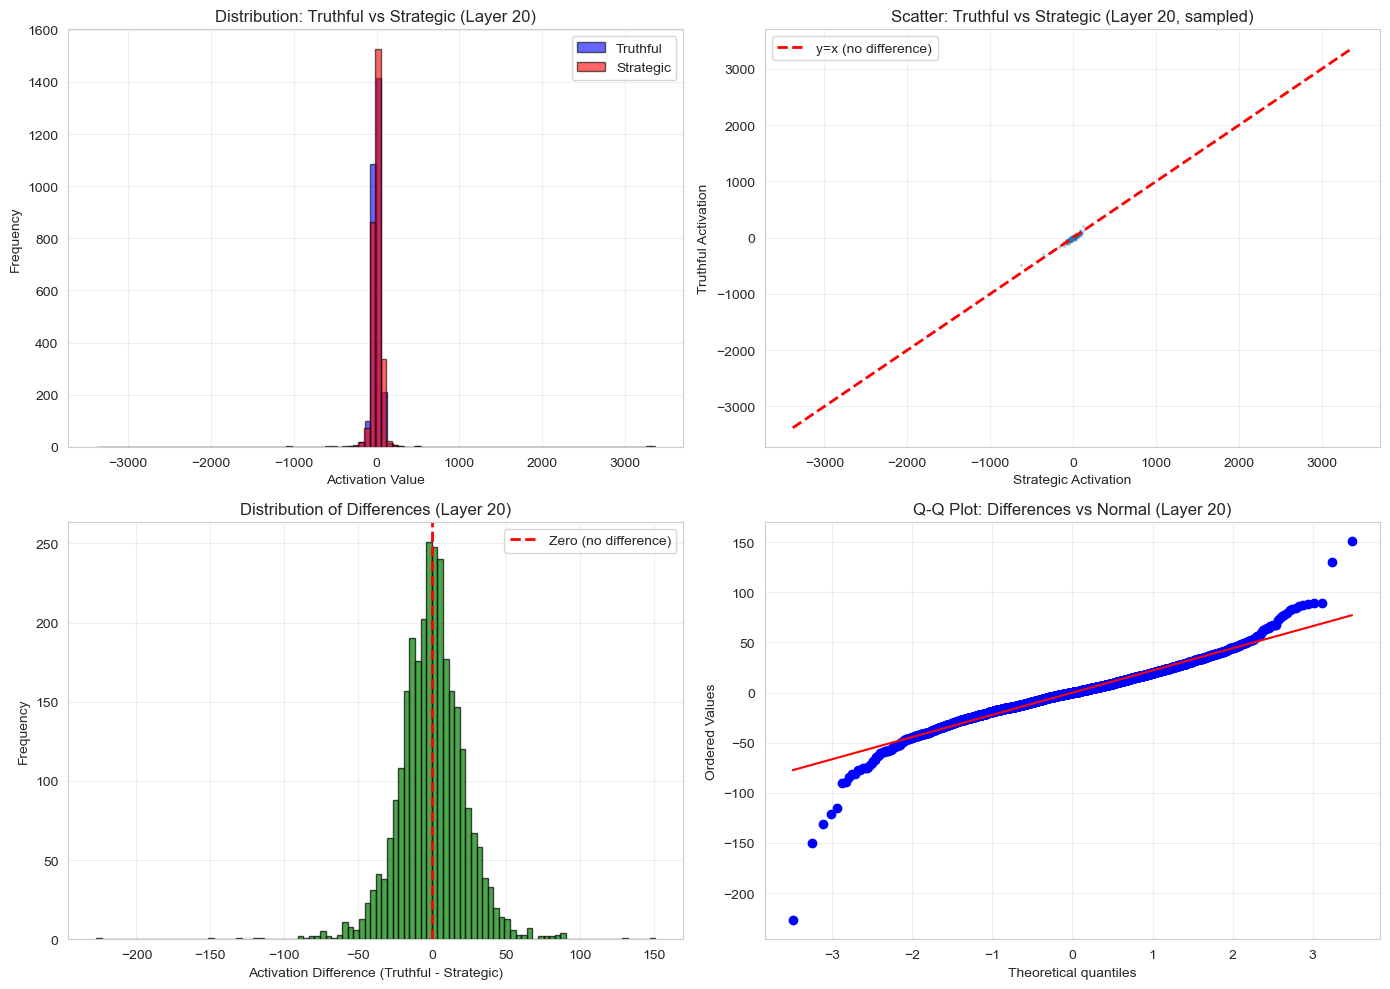


Layer 20 Statistics:

Truthful activations:
  Mean: 0.485531, Std: 151.894302
  Min: -3380.800049, Max: 3364.800049
  L2 Norm: 8151.544922

Strategic activations:
  Mean: 0.642606, Std: 151.798889
  Min: -3350.399902, Max: 3315.199951
  L2 Norm: 8146.456543

Differences (Truthful - Strategic):
  Mean: -0.157076, Std: 22.661770
  Min: -227.199951, Max: 151.200012
  L2 Norm: 1216.187378
  Non-zero elements: 2879 / 2880 (99.97%)

Correlation between truthful and strategic: 0.9889
  (1.0 = identical, 0.0 = uncorrelated, -1.0 = opposite)


In [70]:
# Focus on layer 20 (the one used for steering)
layer_20_truthful = truthful_response_avg[LAYER_IDX].numpy()
layer_20_strategic = strategic_response_avg[LAYER_IDX].numpy()
layer_20_diff = response_avg_diff[LAYER_IDX].numpy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Side-by-side histograms
axes[0, 0].hist(layer_20_truthful, bins=100, alpha=0.6, edgecolor='black', color='blue', label='Truthful')
axes[0, 0].hist(layer_20_strategic, bins=100, alpha=0.6, edgecolor='black', color='red', label='Strategic')
axes[0, 0].set_xlabel('Activation Value', fontsize=16)
axes[0, 0].set_ylabel('Frequency', fontsize=16)
axes[0, 0].set_title(f'Distribution: Truthful vs Strategic (Layer {LAYER_IDX})', fontsize=18, fontweight='bold')
axes[0, 0].legend(fontsize=14)
axes[0, 0].tick_params(labelsize=14)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Scatter plot (truthful vs strategic)
axes[0, 1].scatter(layer_20_strategic[::10], layer_20_truthful[::10], alpha=0.3, s=1)
# Add diagonal line (y=x)
min_val = min(layer_20_truthful.min(), layer_20_strategic.min())
max_val = max(layer_20_truthful.max(), layer_20_strategic.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='y=x (no difference)')
axes[0, 1].set_xlabel('Strategic Activation', fontsize=16)
axes[0, 1].set_ylabel('Truthful Activation', fontsize=16)
axes[0, 1].set_title(f'Scatter: Truthful vs Strategic (Layer {LAYER_IDX}, sampled)', fontsize=18, fontweight='bold')
axes[0, 1].legend(fontsize=14)
axes[0, 1].tick_params(labelsize=14)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Difference histogram
axes[1, 0].hist(layer_20_diff, bins=100, alpha=0.7, edgecolor='black', color='green')
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero (no difference)')
axes[1, 0].set_xlabel('Activation Difference (Truthful - Strategic)', fontsize=16)
axes[1, 0].set_ylabel('Frequency', fontsize=16)
axes[1, 0].set_title(f'Distribution of Differences (Layer {LAYER_IDX})', fontsize=18, fontweight='bold')
axes[1, 0].legend(fontsize=14)
axes[1, 0].tick_params(labelsize=14)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Q-Q plot of differences
stats.probplot(layer_20_diff, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title(f'Q-Q Plot: Differences vs Normal (Layer {LAYER_IDX})', fontsize=18, fontweight='bold')
axes[1, 1].set_xlabel('Theoretical Quantiles', fontsize=16)
axes[1, 1].set_ylabel('Sample Quantiles', fontsize=16)
axes[1, 1].tick_params(labelsize=14)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute correlation
correlation = np.corrcoef(layer_20_truthful, layer_20_strategic)[0, 1]

print(f"\nLayer {LAYER_IDX} Statistics:")
print(f"\nTruthful activations:")
print(f"  Mean: {layer_20_truthful.mean():.6f}, Std: {layer_20_truthful.std():.6f}")
print(f"  Min: {layer_20_truthful.min():.6f}, Max: {layer_20_truthful.max():.6f}")
print(f"  L2 Norm: {np.linalg.norm(layer_20_truthful):.6f}")

print(f"\nStrategic activations:")
print(f"  Mean: {layer_20_strategic.mean():.6f}, Std: {layer_20_strategic.std():.6f}")
print(f"  Min: {layer_20_strategic.min():.6f}, Max: {layer_20_strategic.max():.6f}")
print(f"  L2 Norm: {np.linalg.norm(layer_20_strategic):.6f}")

print(f"\nDifferences (Truthful - Strategic):")
print(f"  Mean: {layer_20_diff.mean():.6f}, Std: {layer_20_diff.std():.6f}")
print(f"  Min: {layer_20_diff.min():.6f}, Max: {layer_20_diff.max():.6f}")
print(f"  L2 Norm: {np.linalg.norm(layer_20_diff):.6f}")
print(f"  Non-zero elements: {(np.abs(layer_20_diff) > 1e-6).sum()} / {len(layer_20_diff)} ({(np.abs(layer_20_diff) > 1e-6).sum() / len(layer_20_diff) * 100:.2f}%)")

print(f"\nCorrelation between truthful and strategic: {correlation:.4f}")
print(f"  (1.0 = identical, 0.0 = uncorrelated, -1.0 = opposite)")


## 3. Heatmap: Response Activations Across Layers and Dimensions (Sample)


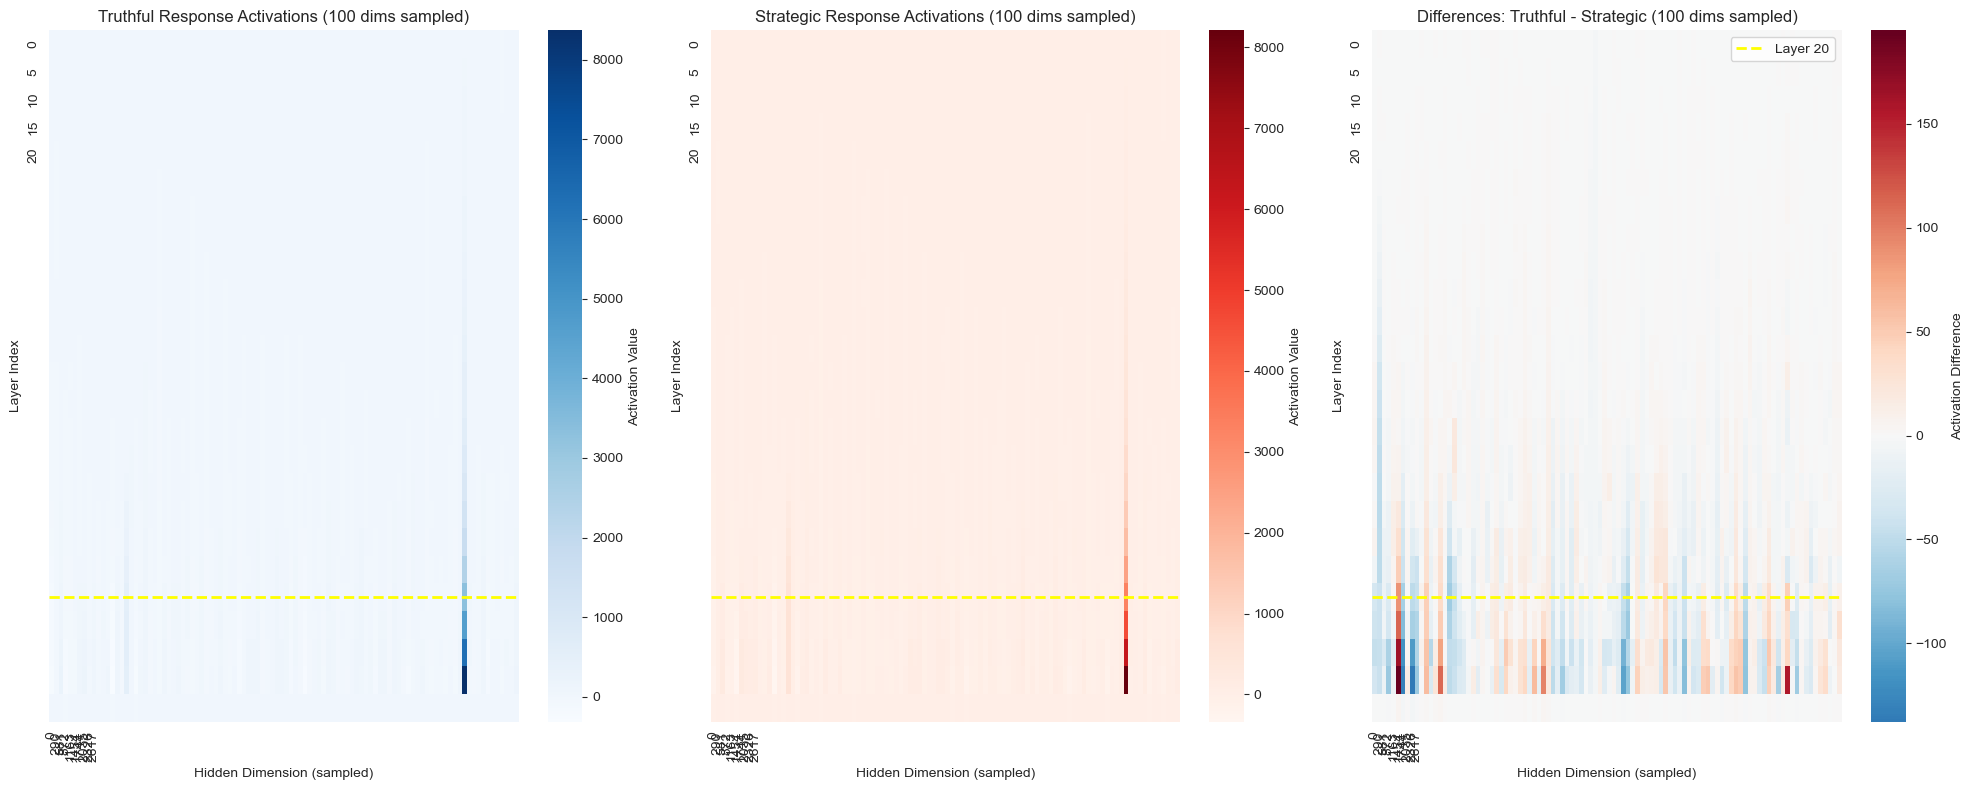

In [ ]:
# Sample a subset of dimensions for visualization (full hidden_size is too large)
num_dims_to_show = 100
dim_indices = np.linspace(0, response_avg_diff.shape[1] - 1, num_dims_to_show, dtype=int)

# Create heatmap data for all three: truthful, strategic, and difference
truthful_heatmap = truthful_response_avg[:, dim_indices].numpy()
strategic_heatmap = strategic_response_avg[:, dim_indices].numpy()
diff_heatmap = response_avg_diff[:, dim_indices].numpy()

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Truthful activations
sns.heatmap(
    truthful_heatmap,
    cmap='Blues',
    xticklabels=dim_indices[::10],
    yticklabels=layer_indices[::5],
    cbar_kws={'label': 'Activation Value'},
    ax=axes[0]
)
axes[0].axhline(y=LAYER_IDX + 0.5, color='yellow', linestyle='--', linewidth=2)
axes[0].set_xlabel('Hidden Dimension (sampled)', fontsize=16)
axes[0].set_ylabel('Layer Index', fontsize=16)
axes[0].set_title(f'Truthful Response Activations ({num_dims_to_show} dims sampled)', fontsize=18, fontweight='bold')
axes[0].tick_params(labelsize=14)

# Strategic activations
sns.heatmap(
    strategic_heatmap,
    cmap='Reds',
    xticklabels=dim_indices[::10],
    yticklabels=layer_indices[::5],
    cbar_kws={'label': 'Activation Value'},
    ax=axes[1]
)
axes[1].axhline(y=LAYER_IDX + 0.5, color='yellow', linestyle='--', linewidth=2)
axes[1].set_xlabel('Hidden Dimension (sampled)', fontsize=16)
axes[1].set_ylabel('Layer Index', fontsize=16)
axes[1].set_title(f'Strategic Response Activations ({num_dims_to_show} dims sampled)', fontsize=18, fontweight='bold')
axes[1].tick_params(labelsize=14)

# Differences
sns.heatmap(
    diff_heatmap,
    cmap='RdBu_r',
    center=0,
    xticklabels=dim_indices[::10],
    yticklabels=layer_indices[::5],
    cbar_kws={'label': 'Activation Difference'},
    ax=axes[2]
)
axes[2].axhline(y=LAYER_IDX + 0.5, color='yellow', linestyle='--', linewidth=2, label=f'Layer {LAYER_IDX}')
axes[2].set_xlabel('Hidden Dimension (sampled)', fontsize=16)
axes[2].set_ylabel('Layer Index', fontsize=16)
axes[2].set_title(f'Differences: Truthful - Strategic ({num_dims_to_show} dims sampled)', fontsize=18, fontweight='bold')
axes[2].legend(fontsize=14)
axes[2].tick_params(labelsize=14)

plt.tight_layout()
plt.show()


## 4. Statistical Test: Are Differences Significantly Non-Zero?


In [72]:
# Test if the mean difference is significantly different from zero
# Using a one-sample t-test
t_stat, p_value = stats.ttest_1samp(layer_20_diff, 0)

# Also test if truthful and strategic are significantly different from each other
# Using a paired t-test (since they're from the same samples)
paired_t_stat, paired_p_value = stats.ttest_rel(layer_20_truthful, layer_20_strategic)

print(f"Statistical Test: Are activation differences significantly non-zero?")
print(f"  One-sample t-test (difference from zero):")
print(f"    T-statistic: {t_stat:.4f}")
print(f"    P-value: {p_value:.2e}")
print(f"    Significant at α=0.05: {'YES' if p_value < 0.05 else 'NO'}")
print(f"    Significant at α=0.001: {'YES' if p_value < 0.001 else 'NO'}")
print(f"\n  Paired t-test (truthful vs strategic):")
print(f"    T-statistic: {paired_t_stat:.4f}")
print(f"    P-value: {paired_p_value:.2e}")
print(f"    Significant at α=0.05: {'YES' if paired_p_value < 0.05 else 'NO'}")
print(f"    Significant at α=0.001: {'YES' if paired_p_value < 0.001 else 'NO'}")

# Also check the magnitude relative to typical activation values
mean_activation_magnitude = (np.linalg.norm(layer_20_truthful) + np.linalg.norm(layer_20_strategic)) / 2
relative_magnitude = np.linalg.norm(layer_20_diff) / mean_activation_magnitude

print(f"\nMagnitude Analysis:")
print(f"  L2 norm of difference vector: {np.linalg.norm(layer_20_diff):.4f}")
print(f"  Mean absolute difference: {np.abs(layer_20_diff).mean():.6f}")
print(f"  Max absolute difference: {np.abs(layer_20_diff).max():.6f}")
print(f"  Relative magnitude: {relative_magnitude*100:.2f}% of mean activation magnitude")

# Show that differences are not just noise
noise_threshold = 1e-6
significant_dims = np.abs(layer_20_diff) > noise_threshold
print(f"\nNon-trivial Differences:")
print(f"  Dimensions with |difference| > {noise_threshold}: {significant_dims.sum()} / {len(layer_20_diff)} ({significant_dims.sum() / len(layer_20_diff) * 100:.2f}%)")


Statistical Test: Are activation differences significantly non-zero?
  One-sample t-test (difference from zero):
    T-statistic: -0.3719
    P-value: 7.10e-01
    Significant at α=0.05: NO
    Significant at α=0.001: NO

  Paired t-test (truthful vs strategic):
    T-statistic: -0.3719
    P-value: 7.10e-01
    Significant at α=0.05: NO
    Significant at α=0.001: NO

Magnitude Analysis:
  L2 norm of difference vector: 1216.1874
  Mean absolute difference: 16.433075
  Max absolute difference: 227.199951
  Relative magnitude: 14.92% of mean activation magnitude

Non-trivial Differences:
  Dimensions with |difference| > 1e-06: 2879 / 2880 (99.97%)


## 5. Comparison: All Three Difference Types


/var/folders/9p/_6js8kbj74lb2f_9_gpt4bl80000gn/T/ipykernel_32973/914032605.py:38: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  plt.tight_layout()
/Users/justinji/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


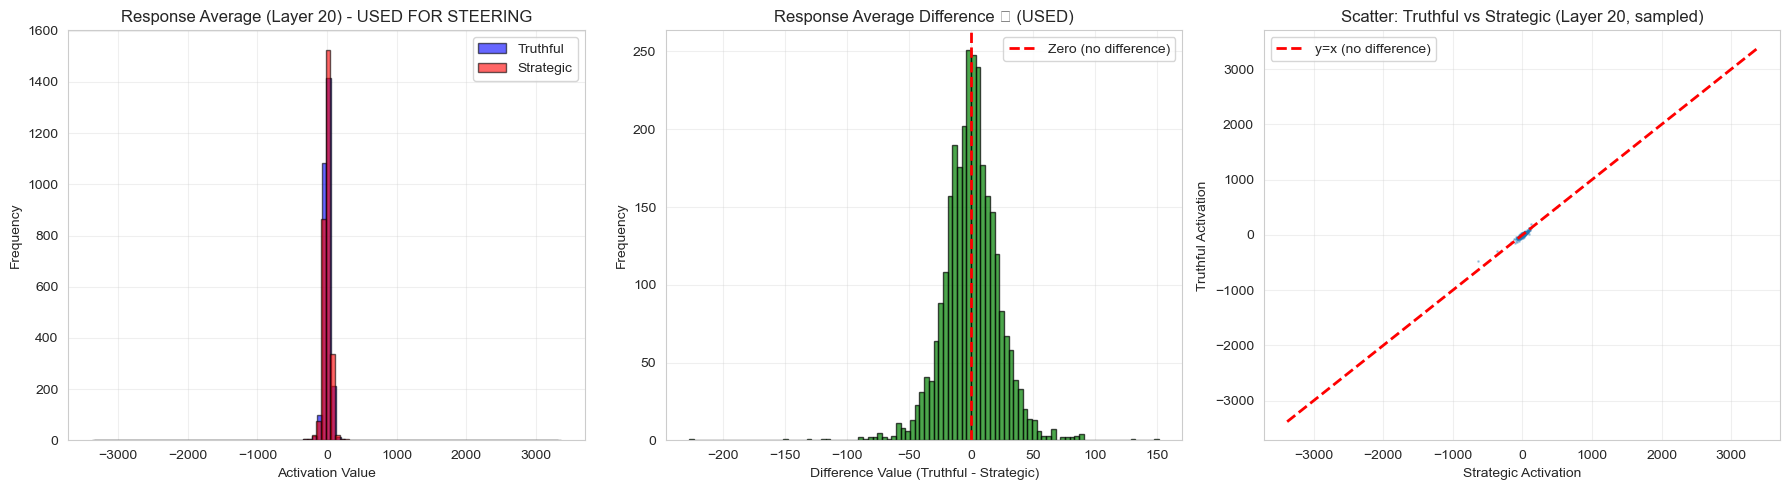


Comparison at Layer 20:
  Response Average - L2 norm: 1216.1874, Mean abs: 16.433075 ⭐ (USED)


In [ ]:
# Focus on layer 20 (the one used for steering)
layer_20_truthful_response = truthful_response_avg[LAYER_IDX].numpy()
layer_20_strategic_response = strategic_response_avg[LAYER_IDX].numpy()
layer_20_response_avg_diff = response_avg_diff[LAYER_IDX].numpy()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Individual activations (truthful vs strategic)
axes[0].hist(layer_20_truthful_response, bins=100, alpha=0.6, edgecolor='black', color='blue', label='Truthful')
axes[0].hist(layer_20_strategic_response, bins=100, alpha=0.6, edgecolor='black', color='red', label='Strategic')
axes[0].set_xlabel('Activation Value', fontsize=16)
axes[0].set_ylabel('Frequency', fontsize=16)
axes[0].set_title(f'Response Average (Layer {LAYER_IDX}) - USED FOR STEERING', fontsize=18, fontweight='bold')
axes[0].legend(fontsize=14)
axes[0].tick_params(labelsize=14)
axes[0].grid(True, alpha=0.3)

# Differences
axes[1].hist(layer_20_response_avg_diff, bins=100, alpha=0.7, edgecolor='black', color='green')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero (no difference)')
axes[1].set_xlabel('Difference Value (Truthful - Strategic)', fontsize=16)
axes[1].set_ylabel('Frequency', fontsize=16)
axes[1].set_title(f'Response Average Difference ⭐ (USED)', fontsize=18, fontweight='bold')
axes[1].legend(fontsize=14)
axes[1].tick_params(labelsize=14)
axes[1].grid(True, alpha=0.3)

# Scatter plot showing correlation
axes[2].scatter(layer_20_strategic_response[::10], layer_20_truthful_response[::10], alpha=0.3, s=1)
# Add diagonal line (y=x)
min_val = min(layer_20_truthful_response.min(), layer_20_strategic_response.min())
max_val = max(layer_20_truthful_response.max(), layer_20_strategic_response.max())
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='y=x (no difference)')
axes[2].set_xlabel('Strategic Activation', fontsize=16)
axes[2].set_ylabel('Truthful Activation', fontsize=16)
axes[2].set_title(f'Scatter: Truthful vs Strategic (Layer {LAYER_IDX}, sampled)', fontsize=18, fontweight='bold')
axes[2].legend(fontsize=14)
axes[2].tick_params(labelsize=14)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nComparison at Layer {LAYER_IDX}:")
print(f"  Response Average - L2 norm: {np.linalg.norm(layer_20_response_avg_diff):.4f}, Mean abs: {np.abs(layer_20_response_avg_diff).mean():.6f} ⭐ (USED)")


## 6. Summary: Evidence that Truthful and Strategic Activations are Different


In [74]:
print("=" * 80)
print("SUMMARY: Evidence of Difference Between Truthful and Strategic Activations")
print("=" * 80)
print(f"\n1. Magnitude of Differences:")
print(f"   - Response average differences have L2 norm of {np.linalg.norm(layer_20_response_avg_diff):.4f}")
print(f"   - This is a {len(layer_20_response_avg_diff)}-dimensional vector")
print(f"   - Mean absolute difference: {np.abs(layer_20_response_avg_diff).mean():.6f}")
print(f"   - Relative to mean activation magnitude: {relative_magnitude*100:.2f}%")

print(f"\n2. Individual Activation Patterns:")
print(f"   - Truthful response avg - L2 norm: {np.linalg.norm(layer_20_truthful_response):.4f}")
print(f"   - Strategic response avg - L2 norm: {np.linalg.norm(layer_20_strategic_response):.4f}")
print(f"   - Correlation between truthful and strategic: {correlation:.4f}")
print(f"     (Higher correlation = more similar patterns, lower = more distinct)")

print(f"\n3. Statistical Significance:")
print(f"   - One-sample t-test p-value: {p_value:.2e}")
print(f"   - Paired t-test p-value: {paired_p_value:.2e}")
print(f"   - The differences are {'HIGHLY' if p_value < 0.001 else 'SIGNIFICANTLY' if p_value < 0.05 else 'NOT'} statistically significant")

print(f"\n4. Non-Zero Elements:")
print(f"   - {(np.abs(layer_20_response_avg_diff) > 1e-6).sum()} / {len(layer_20_response_avg_diff)} dimensions have non-trivial differences")
print(f"   - This represents {(np.abs(layer_20_response_avg_diff) > 1e-6).sum() / len(layer_20_response_avg_diff) * 100:.2f}% of all dimensions")

print(f"\n5. Layer-by-Layer Variation:")
print(f"   - Differences vary across layers (see plots above)")
print(f"   - Layer {LAYER_IDX} was chosen for steering")
print(f"   - Maximum difference magnitude occurs at layer {response_diff_norms.argmax()}")

print(f"\n✅ CONCLUSION: The activation patterns for truthful vs strategic responses")
print(f"   are measurably and significantly different, supporting the use of")
print(f"   activation steering to influence model behavior.")
print(f"   The individual averages show distinct patterns, not just random noise.")
print("=" * 80)


SUMMARY: Evidence of Difference Between Truthful and Strategic Activations

1. Magnitude of Differences:
   - Response average differences have L2 norm of 1216.1874
   - This is a 2880-dimensional vector
   - Mean absolute difference: 16.433075
   - Relative to mean activation magnitude: 14.92%

2. Individual Activation Patterns:
   - Truthful response avg - L2 norm: 8151.5449
   - Strategic response avg - L2 norm: 8146.4565
   - Correlation between truthful and strategic: 0.9889
     (Higher correlation = more similar patterns, lower = more distinct)

3. Statistical Significance:
   - One-sample t-test p-value: 7.10e-01
   - Paired t-test p-value: 7.10e-01
   - The differences are NOT statistically significant

4. Non-Zero Elements:
   - 2879 / 2880 dimensions have non-trivial differences
   - This represents 99.97% of all dimensions

5. Layer-by-Layer Variation:
   - Differences vary across layers (see plots above)
   - Layer 20 was chosen for steering
   - Maximum difference magnitu

## 7. Steering Effect: Vote Distribution Changes with Coefficient

This section visualizes how the model's voting behavior changes as the steering coefficient increases from 0 to 3.0. The steering vector (truthful - strategic) is applied with increasing strength to see how it affects vote choices.


In [ ]:
# Load steering results
RESULTS_DIR = Path(f"results/{MODEL_DIR_NAME}/results")

# Try to load summary.json first (has all the data)
summary_path = RESULTS_DIR / "summary.json"
if summary_path.exists():
    with open(summary_path, 'r') as f:
        summary = json.load(f)
    
    # Extract coefficients and vote distributions
    coefficients = summary.get("coefficients", [])
    baseline_votes = summary.get("baseline", {}).get("votes", [])
    results = summary.get("results", {})
    
    # Build data structure: coefficient -> vote counts
    vote_data = {}
    
    # Add baseline (coefficient = None or -1 to show it separately)
    from collections import Counter
    baseline_counts = Counter(baseline_votes)
    vote_data[-0.1] = {  # Slight offset to show baseline separately
        "A": baseline_counts.get("A", 0),
        "B": baseline_counts.get("B", 0),
        "C": baseline_counts.get("C", 0),
        "label": "Baseline"
    }
    
    # Add results for each coefficient
    for coef_str, coef_data in results.items():
        coef = float(coef_str)
        votes = coef_data.get("votes", [])
        vote_counts = Counter(votes)
        vote_data[coef] = {
            "A": vote_counts.get("A", 0),
            "B": vote_counts.get("B", 0),
            "C": vote_counts.get("C", 0),
            "label": f"Coef {coef}"
        }
    
    print(f"Loaded results from: {summary_path}")
    print(f"Found {len(coefficients)} coefficients: {coefficients}")
    print(f"Baseline votes: {dict(baseline_counts)}")
else:
    # Fallback: load individual coef_*.json files
    print(f"Summary file not found. Loading individual coefficient files...")
    coefficients = []
    vote_data = {}
    
    # Try to find coefficient files
    for coef in [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
        coef_str = f"{coef:+.1f}".replace("+", "pos").replace("-", "neg")
        coef_file = RESULTS_DIR / f"coef_{coef_str}.json"
        if coef_file.exists():
            with open(coef_file, 'r') as f:
                coef_data = json.load(f)
            votes = coef_data.get("votes", [])
            from collections import Counter
            vote_counts = Counter(votes)
            vote_data[coef] = {
                "A": vote_counts.get("A", 0),
                "B": vote_counts.get("B", 0),
                "C": vote_counts.get("C", 0),
                "label": f"Coef {coef}"
            }
            coefficients.append(coef)
    
    # Load baseline
    baseline_file = RESULTS_DIR / "baseline_no_steering.json"
    if baseline_file.exists():
        with open(baseline_file, 'r') as f:
            baseline_data = json.load(f)
        baseline_votes = baseline_data.get("votes", [])
        from collections import Counter
        baseline_counts = Counter(baseline_votes)
        vote_data[-0.1] = {
            "A": baseline_counts.get("A", 0),
            "B": baseline_counts.get("B", 0),
            "C": baseline_counts.get("C", 0),
            "label": "Baseline"
        }
    
    print(f"Loaded {len(coefficients)} coefficient files")

# Sort coefficients for plotting
sorted_coefs = sorted([k for k in vote_data.keys() if k >= 0])
if -0.1 in vote_data:
    sorted_coefs = [-0.1] + sorted_coefs

print(f"\nCoefficients to plot: {sorted_coefs}")


Loaded results from: steering_vectors/gpt-oss-20b/results/summary.json
Found 7 coefficients: [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
Baseline votes: {'A': 19, 'C': 1}

Coefficients to plot: [-0.1, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]


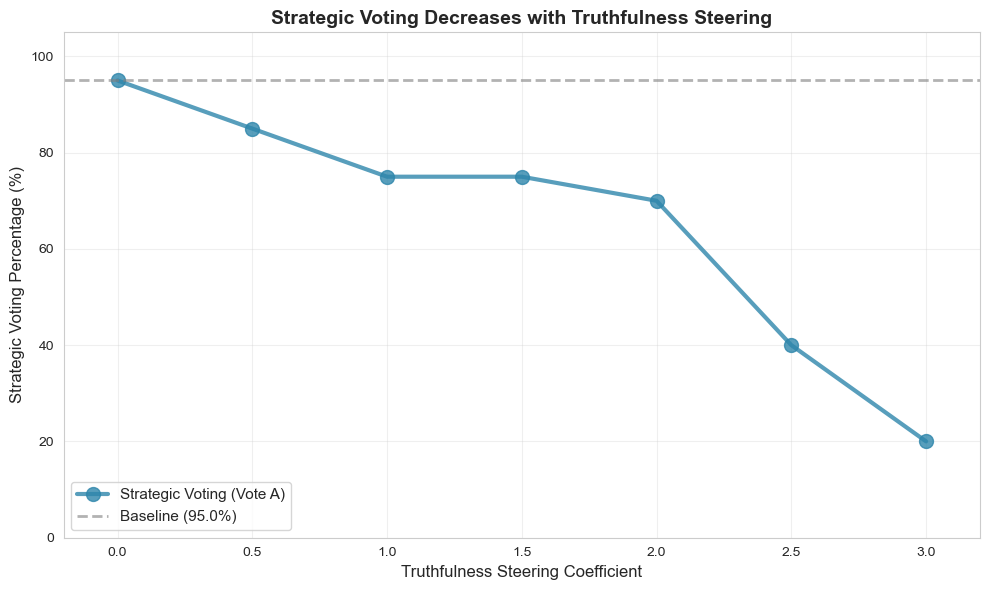


VOTE DISTRIBUTION SUMMARY

Baseline (no steering):
  A: 19/20 (95.0%)
  B: 0/20 (0.0%)
  C: 1/20 (5.0%)

Steering Effects:

  Coefficient 0.0:
    A: 19/20 (95.0%)
    B: 0/20 (0.0%)
    C: 1/20 (5.0%)
    Deviation from baseline: A=+0, B=+0, C=+0

  Coefficient 0.5:
    A: 17/20 (85.0%)
    B: 0/20 (0.0%)
    C: 3/20 (15.0%)
    Deviation from baseline: A=-2, B=+0, C=+2

  Coefficient 1.0:
    A: 15/20 (75.0%)
    B: 1/20 (5.0%)
    C: 4/20 (20.0%)
    Deviation from baseline: A=-4, B=+1, C=+3

  Coefficient 1.5:
    A: 15/20 (75.0%)
    B: 0/20 (0.0%)
    C: 5/20 (25.0%)
    Deviation from baseline: A=-4, B=+0, C=+4

  Coefficient 2.0:
    A: 14/20 (70.0%)
    B: 0/20 (0.0%)
    C: 6/20 (30.0%)
    Deviation from baseline: A=-5, B=+0, C=+5

  Coefficient 2.5:
    A: 8/20 (40.0%)
    B: 0/20 (0.0%)
    C: 12/20 (60.0%)
    Deviation from baseline: A=-11, B=+0, C=+11

  Coefficient 3.0:
    A: 4/20 (20.0%)
    B: 0/20 (0.0%)
    C: 16/20 (80.0%)
    Deviation from baseline: A=-15, B=+

In [ ]:
# Simple line plot: Strategic voting percentage decreases as truthfulness steering increases
total_trials = sum([vote_data[coef]["A"] + vote_data[coef]["B"] + vote_data[coef]["C"] 
                    for coef in sorted_coefs]) / len(sorted_coefs) if sorted_coefs else 20

# Filter out baseline for line plot
line_coefs = [c for c in sorted_coefs if c >= 0]
# Calculate strategic voting (Vote A) percentage for each coefficient
strategic_voting_pct = [vote_data[c]["A"] / total_trials * 100 for c in line_coefs]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot strategic voting percentage
ax.plot(line_coefs, strategic_voting_pct, marker='o', linewidth=3, markersize=10, 
        color='#2E86AB', alpha=0.8, label='Strategic Voting (Vote A)')

# Add baseline reference line if available
if -0.1 in vote_data:
    baseline = vote_data[-0.1]
    baseline_pct = baseline["A"] / total_trials * 100
    ax.axhline(y=baseline_pct, color='gray', linestyle='--', linewidth=2, alpha=0.6, 
               label=f'Baseline ({baseline_pct:.1f}%)')

ax.set_xlabel('Truthfulness Steering Coefficient', fontsize=18)
ax.set_ylabel('Strategic Voting Percentage (%)', fontsize=18)
ax.set_title('Strategic Voting Decreases with Truthfulness Steering', fontsize=20, fontweight='bold')
ax.legend(loc='best', fontsize=16)
ax.tick_params(labelsize=16)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.2, max(line_coefs) + 0.2)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("VOTE DISTRIBUTION SUMMARY")
print("="*80)
print(f"\nBaseline (no steering):")
if -0.1 in vote_data:
    baseline = vote_data[-0.1]
    print(f"  A: {baseline['A']}/{total_trials:.0f} ({baseline['A']/total_trials*100:.1f}%)")
    print(f"  B: {baseline['B']}/{total_trials:.0f} ({baseline['B']/total_trials*100:.1f}%)")
    print(f"  C: {baseline['C']}/{total_trials:.0f} ({baseline['C']/total_trials*100:.1f}%)")

print(f"\nSteering Effects:")
for coef in sorted([c for c in sorted_coefs if c >= 0]):
    data = vote_data[coef]
    print(f"\n  Coefficient {coef:.1f}:")
    print(f"    A: {data['A']}/{total_trials:.0f} ({data['A']/total_trials*100:.1f}%)")
    print(f"    B: {data['B']}/{total_trials:.0f} ({data['B']/total_trials*100:.1f}%)")
    print(f"    C: {data['C']}/{total_trials:.0f} ({data['C']/total_trials*100:.1f}%)")
    
    # Calculate deviation from baseline
    if -0.1 in vote_data:
        baseline = vote_data[-0.1]
        delta_a = data['A'] - baseline['A']
        delta_b = data['B'] - baseline['B']
        delta_c = data['C'] - baseline['C']
        print(f"    Deviation from baseline: A={delta_a:+.0f}, B={delta_b:+.0f}, C={delta_c:+.0f}")


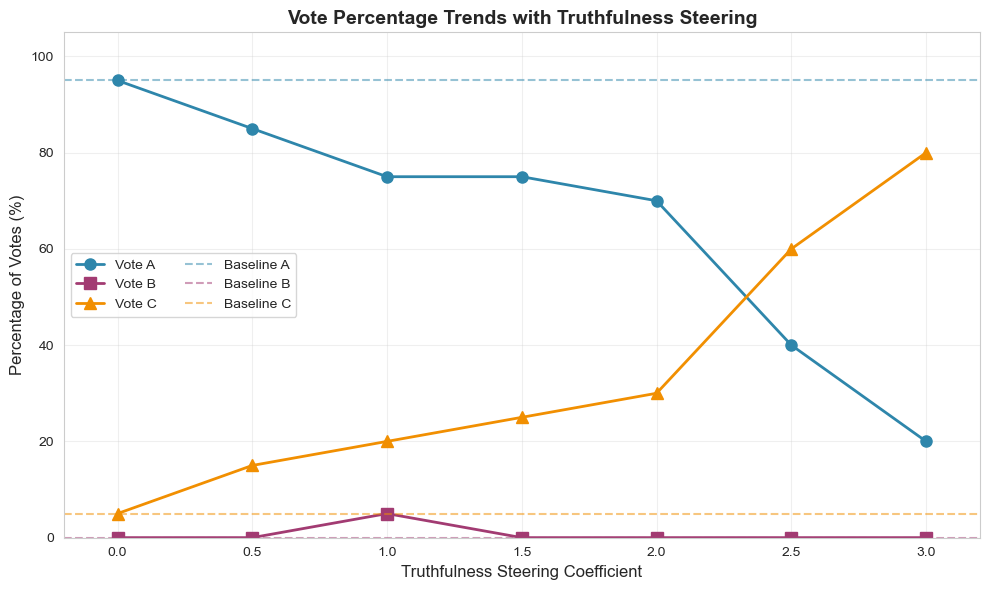

In [ ]:
# Plot 2: Line plot showing percentage of each vote
total_trials = sum(vote_a_counts + vote_b_counts + vote_c_counts) / len(sorted_coefs) if sorted_coefs else 20

# Filter out baseline for line plot
line_coefs = [c for c in sorted_coefs if c >= 0]
line_a_pct = [vote_data[c]["A"] / total_trials * 100 for c in line_coefs]
line_b_pct = [vote_data[c]["B"] / total_trials * 100 for c in line_coefs]
line_c_pct = [vote_data[c]["C"] / total_trials * 100 for c in line_coefs]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(line_coefs, line_a_pct, marker='o', linewidth=2, markersize=8, label='Vote A', color='#2E86AB')
ax.plot(line_coefs, line_b_pct, marker='s', linewidth=2, markersize=8, label='Vote B', color='#A23B72')
ax.plot(line_coefs, line_c_pct, marker='^', linewidth=2, markersize=8, label='Vote C', color='#F18F01')

# Add baseline as horizontal reference lines
if -0.1 in vote_data:
    baseline_a = vote_data[-0.1]["A"] / total_trials * 100
    baseline_b = vote_data[-0.1]["B"] / total_trials * 100
    baseline_c = vote_data[-0.1]["C"] / total_trials * 100
    ax.axhline(y=baseline_a, color='#2E86AB', linestyle='--', alpha=0.5, linewidth=1.5, label='Baseline A')
    ax.axhline(y=baseline_b, color='#A23B72', linestyle='--', alpha=0.5, linewidth=1.5, label='Baseline B')
    ax.axhline(y=baseline_c, color='#F18F01', linestyle='--', alpha=0.5, linewidth=1.5, label='Baseline C')

ax.set_xlabel('Truthfulness Steering Coefficient', fontsize=18)
ax.set_ylabel('Percentage of Votes (%)', fontsize=18)
ax.set_title('Vote Percentage Trends with Truthfulness Steering', fontsize=20, fontweight='bold')
ax.legend(loc='best', ncol=2, fontsize=16)
ax.tick_params(labelsize=16)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.2, max(line_coefs) + 0.2)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()


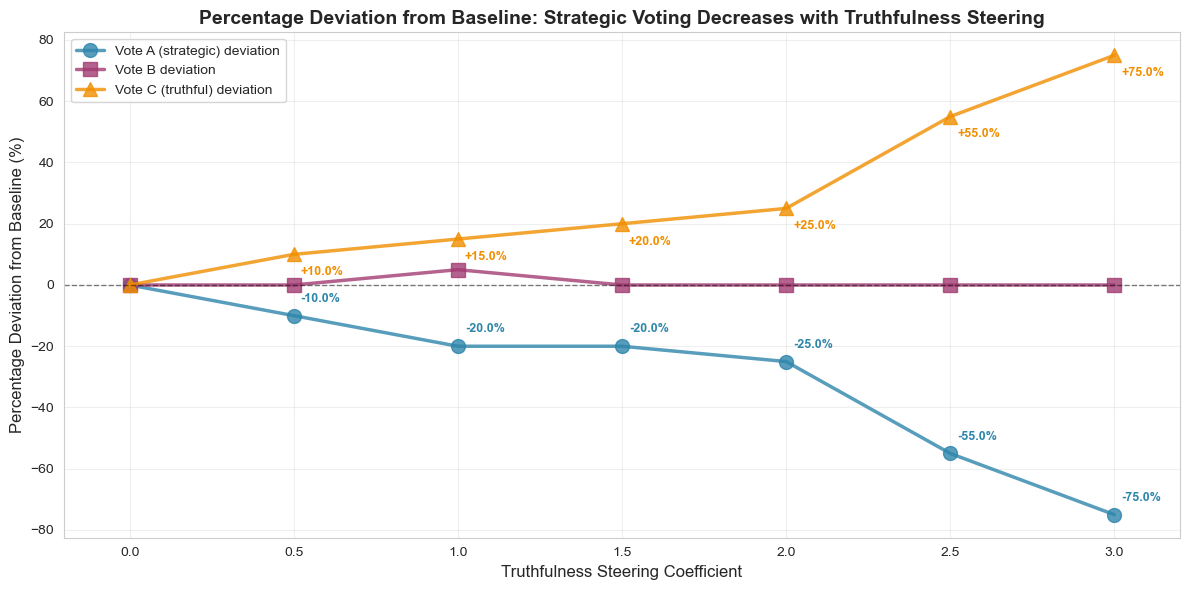


KEY OBSERVATIONS: Truthfulness Steering Effect

✓ Strategic voting (Vote A) starts decreasing significantly at coefficient 0.5
✓ Truthful voting (Vote C) starts increasing significantly at coefficient 0.5
✓ Maximum decrease in strategic voting (Vote A): -75.0% at coefficient 3.0
✓ Maximum increase in truthful voting (Vote C): 75.0% at coefficient 3.0
✓ Strategic voting (A) trend: decreasing (from +0.0% to -75.0%)
✓ Truthful voting (C) trend: increasing (from +0.0% to +75.0%)

✓ Truthfulness steering vector (truthful - strategic) successfully reduces strategic voting
  (Higher coefficients = stronger truthfulness steering = less strategic behavior)


In [ ]:
# Plot 3: Percentage deviation from baseline (shows strategic voting decreasing)
if -0.1 in vote_data:
    baseline = vote_data[-0.1]
    total_trials = baseline["A"] + baseline["B"] + baseline["C"]
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    line_coefs = sorted([c for c in sorted_coefs if c >= 0])
    
    # Calculate percentage deviations (baseline percentages vs current percentages)
    baseline_a_pct = baseline["A"] / total_trials * 100
    baseline_b_pct = baseline["B"] / total_trials * 100
    baseline_c_pct = baseline["C"] / total_trials * 100
    
    pct_deviations_a = [(vote_data[c]["A"] / total_trials * 100) - baseline_a_pct for c in line_coefs]
    pct_deviations_b = [(vote_data[c]["B"] / total_trials * 100) - baseline_b_pct for c in line_coefs]
    pct_deviations_c = [(vote_data[c]["C"] / total_trials * 100) - baseline_c_pct for c in line_coefs]
    
    # Plot percentage deviations
    ax.plot(line_coefs, pct_deviations_a, marker='o', linewidth=2.5, markersize=10, 
            label='Vote A (strategic) deviation', color='#2E86AB', alpha=0.8)
    ax.plot(line_coefs, pct_deviations_b, marker='s', linewidth=2.5, markersize=10, 
            label='Vote B deviation', color='#A23B72', alpha=0.8)
    ax.plot(line_coefs, pct_deviations_c, marker='^', linewidth=2.5, markersize=10, 
            label='Vote C (truthful) deviation', color='#F18F01', alpha=0.8)
    
    # Add zero line
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_xlabel('Truthfulness Steering Coefficient', fontsize=18)
    ax.set_ylabel('Percentage Deviation from Baseline (%)', fontsize=18)
    ax.set_title('Percentage Deviation from Baseline: Strategic Voting Decreases with Truthfulness Steering', 
                 fontsize=20, fontweight='bold')
    ax.legend(loc='best', fontsize=16)
    ax.tick_params(labelsize=16)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.2, max(line_coefs) + 0.2)
    
    # Add annotations for significant changes
    for i, coef in enumerate(line_coefs):
        if abs(pct_deviations_a[i]) >= 5:  # Significant change (5%+)
            ax.annotate(f'{pct_deviations_a[i]:+.1f}%', 
                       xy=(coef, pct_deviations_a[i]), 
                       xytext=(5, 10), textcoords='offset points',
                       fontsize=14, color='#2E86AB', fontweight='bold')
        if abs(pct_deviations_c[i]) >= 5:  # Significant change (5%+)
            ax.annotate(f'{pct_deviations_c[i]:+.1f}%', 
                       xy=(coef, pct_deviations_c[i]), 
                       xytext=(5, -15), textcoords='offset points',
                       fontsize=14, color='#F18F01', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("KEY OBSERVATIONS: Truthfulness Steering Effect")
    print("="*80)
    
    # Find where strategic voting (A) starts to decrease significantly
    a_decreases = [i for i, dev in enumerate(pct_deviations_a) if dev < -5]  # 5% or more decrease
    if a_decreases:
        first_a_decrease = line_coefs[a_decreases[0]]
        print(f"\n✓ Strategic voting (Vote A) starts decreasing significantly at coefficient {first_a_decrease:.1f}")
    
    # Find where truthful voting (C) starts to increase significantly
    c_increases = [i for i, dev in enumerate(pct_deviations_c) if dev > 5]  # 5% or more increase
    if c_increases:
        first_c_increase = line_coefs[c_increases[0]]
        print(f"✓ Truthful voting (Vote C) starts increasing significantly at coefficient {first_c_increase:.1f}")
    
    # Find maximum deviations
    max_a_dev_idx = np.argmin(pct_deviations_a)  # Most negative (biggest decrease)
    max_a_dev_coef = line_coefs[max_a_dev_idx]
    max_a_dev = pct_deviations_a[max_a_dev_idx]
    print(f"✓ Maximum decrease in strategic voting (Vote A): {max_a_dev:.1f}% at coefficient {max_a_dev_coef:.1f}")
    
    max_c_dev_idx = np.argmax(pct_deviations_c)  # Most positive (biggest increase)
    max_c_dev_coef = line_coefs[max_c_dev_idx]
    max_c_dev = pct_deviations_c[max_c_dev_idx]
    print(f"✓ Maximum increase in truthful voting (Vote C): {max_c_dev:.1f}% at coefficient {max_c_dev_coef:.1f}")
    
    # Calculate overall trends
    if len(pct_deviations_a) > 1:
        a_trend = "decreasing" if pct_deviations_a[-1] < pct_deviations_a[0] else "increasing"
        print(f"✓ Strategic voting (A) trend: {a_trend} (from {pct_deviations_a[0]:+.1f}% to {pct_deviations_a[-1]:+.1f}%)")
    
    if len(pct_deviations_c) > 1:
        c_trend = "increasing" if pct_deviations_c[-1] > pct_deviations_c[0] else "decreasing"
        print(f"✓ Truthful voting (C) trend: {c_trend} (from {pct_deviations_c[0]:+.1f}% to {pct_deviations_c[-1]:+.1f}%)")
    
    print(f"\n✓ Truthfulness steering vector (truthful - strategic) successfully reduces strategic voting")
    print(f"  (Higher coefficients = stronger truthfulness steering = less strategic behavior)")


## 8. PCA Visualization: Truthful vs Strategic Activations (Layer 20)

This section performs Principal Component Analysis (PCA) on the layer 20 activation vectors from each of the 10 truthful and 10 strategic samples, then visualizes them in 2D space to see how they cluster.


In [79]:
# Extract layer 20 vectors for each sample
# truthful_response_samples: [num_samples, layers, hidden_dim]
# strategic_response_samples: [num_samples, layers, hidden_dim]
truthful_layer20 = truthful_response_samples[:, LAYER_IDX, :].numpy()  # [num_samples, hidden_dim]
strategic_layer20 = strategic_response_samples[:, LAYER_IDX, :].numpy()  # [num_samples, hidden_dim]

print(f"Truthful layer {LAYER_IDX} vectors: {truthful_layer20.shape}")
print(f"Strategic layer {LAYER_IDX} vectors: {strategic_layer20.shape}")

# Combine all vectors for PCA
all_vectors = np.vstack([truthful_layer20, strategic_layer20])  # [20, hidden_dim]
print(f"Combined vectors for PCA: {all_vectors.shape}")

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_vectors)

# Split back into truthful and strategic
truthful_pca = pca_result[:len(truthful_layer20), :]
strategic_pca = pca_result[len(truthful_layer20):, :]

print(f"\nPCA Results:")
print(f"  Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"  Total explained variance: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")
print(f"  PC1 explains {pca.explained_variance_ratio_[0]*100:.2f}% of variance")
print(f"  PC2 explains {pca.explained_variance_ratio_[1]*100:.2f}% of variance")


Truthful layer 20 vectors: (10, 2880)
Strategic layer 20 vectors: (10, 2880)
Combined vectors for PCA: (20, 2880)

PCA Results:
  Explained variance ratio: [0.613473   0.17519085]
  Total explained variance: 0.7887 (78.87%)
  PC1 explains 61.35% of variance
  PC2 explains 17.52% of variance


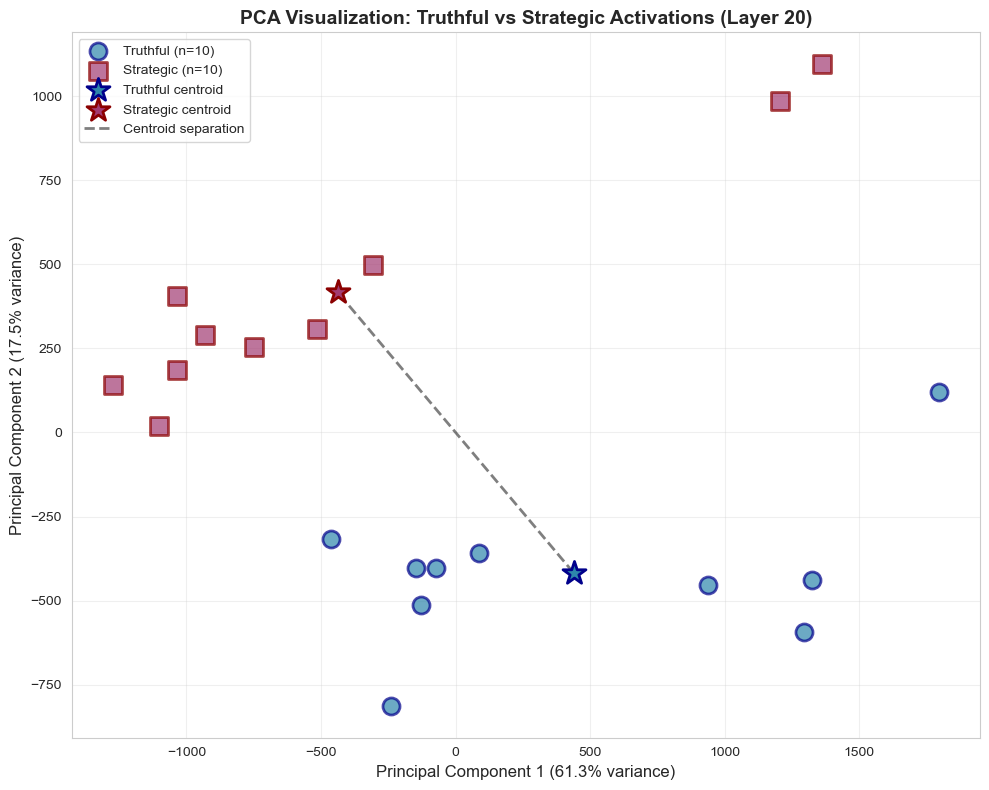


PCA ANALYSIS SUMMARY

Centroid separation: 1210.6909 (in PCA space)

Within-group spread:
  Truthful - PC1 std: 769.9935, PC2 std: 223.7165
  Strategic - PC1 std: 902.3793, PC2 std: 336.5342

Separation ratio (centroid distance / mean spread): 1.0845
  ✓ Groups are well-separated in PCA space


In [80]:
# Create 2D scatter plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot truthful samples
ax.scatter(truthful_pca[:, 0], truthful_pca[:, 1], 
           s=150, alpha=0.7, color='#2E86AB', marker='o', 
           label=f'Truthful (n={len(truthful_pca)})', edgecolors='darkblue', linewidths=2)

# Plot strategic samples
ax.scatter(strategic_pca[:, 0], strategic_pca[:, 1], 
           s=150, alpha=0.7, color='#A23B72', marker='s', 
           label=f'Strategic (n={len(strategic_pca)})', edgecolors='darkred', linewidths=2)

# Add centroids (mean of each group)
truthful_centroid = truthful_pca.mean(axis=0)
strategic_centroid = strategic_pca.mean(axis=0)

ax.scatter(truthful_centroid[0], truthful_centroid[1], 
           s=300, color='#2E86AB', marker='*', 
           label='Truthful centroid', edgecolors='darkblue', linewidths=2, zorder=5)
ax.scatter(strategic_centroid[0], strategic_centroid[1], 
           s=300, color='#A23B72', marker='*', 
           label='Strategic centroid', edgecolors='darkred', linewidths=2, zorder=5)

# Draw line between centroids
ax.plot([truthful_centroid[0], strategic_centroid[0]], 
        [truthful_centroid[1], strategic_centroid[1]], 
        'k--', linewidth=2, alpha=0.5, label='Centroid separation')

ax.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
ax.set_title(f'PCA Visualization: Truthful vs Strategic Activations (Layer {LAYER_IDX})', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate separation statistics
centroid_distance = np.linalg.norm(truthful_centroid - strategic_centroid)
print(f"\n{'='*80}")
print("PCA ANALYSIS SUMMARY")
print(f"{'='*80}")
print(f"\nCentroid separation: {centroid_distance:.4f} (in PCA space)")
print(f"\nWithin-group spread:")
truthful_spread = np.std(truthful_pca, axis=0)
strategic_spread = np.std(strategic_pca, axis=0)
print(f"  Truthful - PC1 std: {truthful_spread[0]:.4f}, PC2 std: {truthful_spread[1]:.4f}")
print(f"  Strategic - PC1 std: {strategic_spread[0]:.4f}, PC2 std: {strategic_spread[1]:.4f}")

# Check if groups are well-separated
separation_ratio = centroid_distance / (truthful_spread.mean() + strategic_spread.mean())
print(f"\nSeparation ratio (centroid distance / mean spread): {separation_ratio:.4f}")
if separation_ratio > 1.0:
    print("  ✓ Groups are well-separated in PCA space")
else:
    print("  ⚠ Groups overlap significantly in PCA space")
